In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import timedelta

In [237]:
# Go on your Substack subscriber page, and click on the little download icon on the bottom right of the chart.
# rename the file to substack.csv and put it in the running directory

df = pd.read_csv('data/substack.csv')

df['date'] = pd.to_datetime(df['date'])


In [238]:
print(f'You have {df.shape[0]} days of data.')
df.head()

You have 123 days of data.


,date,emails
0,2023-04-02,48
1,2023-04-03,61
2,2023-04-04,68
3,2023-04-05,73
4,2023-04-06,86


Let's suppose the growth is linear over time. This is a fair estimation in most cases or at least could be seen as a lower bound estimation as it doesn't integrate any possible virality. 


Then getting the forecast is as easy as computing the slope (a) and intercept (b)  of the line: y = ax + b
We do that based on our data usinga linear regression.

In [214]:
# Creating numeric representation of dates for the regression model
df['date_num'] = (df['date'] - df['date'].min()) / np.timedelta64(1, 'D')

# Train a simple linear regression model
X = df['date_num'].values.reshape(-1,1)
y = df['emails'].values.reshape(-1,1)

In [215]:
regressor = LinearRegression()  
regressor.fit(X, y) #training the algorithm

# To get lower and upper bounds, we calculate the residuals (differences between observed and predicted values)
residuals = y - regressor.predict(X)
std_error = np.std(residuals)

In [224]:
print("The slope of the linear regression model is: ", round(regressor.coef_[0][0],2))
print("This corresponds to the average number of new subscribers per day.")

The slope of the linear regression model is:  6.8
This corresponds to the average number of new subscribers per day.


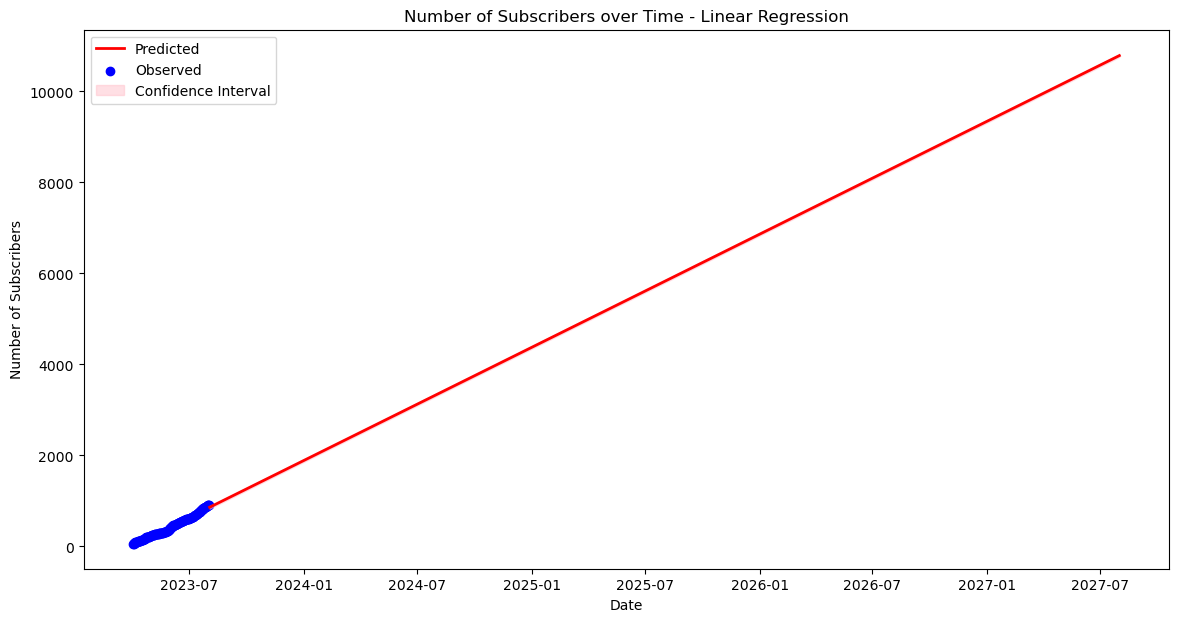

In [217]:
number_of_years = 4
next_year = np.array(range(int(df['date_num'].max()+1), int(df['date_num'].max()+(365*number_of_years+1)))).reshape(-1,1)
y_pred = regressor.predict(next_year)
lower_bound = y_pred - std_error
upper_bound = y_pred + std_error

# Converting numeric dates back to datetime for plotting
next_year_dates = df['date'].min() + pd.to_timedelta(next_year.ravel(), unit='D')

# Plotting data
plt.figure(figsize=(14,7))
plt.scatter(df['date'], df['emails'], color='blue', label='Observed')  
plt.plot(next_year_dates, y_pred, color='red', linewidth=2, label='Predicted') 
plt.fill_between(next_year_dates, lower_bound.ravel(), upper_bound.ravel(), color='pink', alpha=.5, label='Confidence Interval')  
plt.title('Number of Subscribers over Time - Linear Regression')  
plt.xlabel('Date')  
plt.ylabel('Number of Subscribers')  
plt.legend()
plt.show()

# ARIMA model

In [111]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from pmdarima.arima import auto_arima

In [249]:

# Set 'date' as the index
df.set_index('date', inplace=True)

# Resample the data to daily frequency
df = df.resample('D').asfreq()

# Forward fill any missing data
df['emails'] = df['emails'].ffill()


In [229]:
# Finding the best Arima parameters based on data
model = auto_arima(df['emails'], seasonal=False, stepwise=True, 
                   suppress_warnings=True, error_action="ignore", trace=True)

model_fit = model.fit(df['emails'])

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=698.186, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=730.901, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=712.375, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=694.457, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=728.923, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=694.671, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=694.836, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=692.459, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=692.674, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=692.836, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=710.399, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=694.657, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.996 seconds


In [230]:
# Fit the ARIMA model

model_fit = ARIMA(df['emails'], order=(0,2,1)).fit()

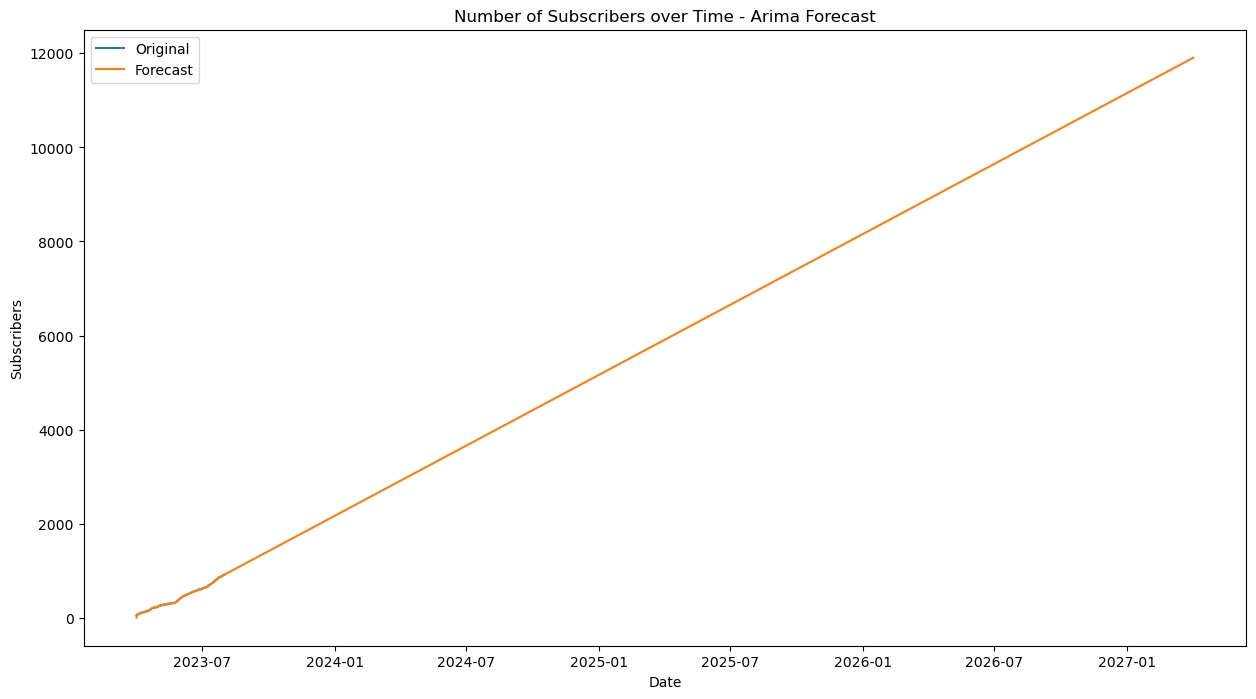

In [231]:
# Forecast the next 3 years
pred = model_fit.predict(start=pd.to_datetime(df.index.min()), 
                     end=pd.to_datetime(df.index.min()) + pd.DateOffset(years=4))

# Plot the results
plt.figure(figsize=(15, 8))
plt.xlabel('Date')
plt.ylabel('Subscribers')
plt.title('Number of Subscribers over Time - Arima Forecast')  
plt.plot(df['emails'], label='Original')
plt.plot(pred, label='Forecast')
plt.legend()
plt.show()

In [232]:
pred

2023-04-02        0.000000
2023-04-03       72.000017
2023-04-04       74.000269
2023-04-05       77.832800
2023-04-06       80.935993
                  ...     
2027-03-29    11874.422118
2027-03-30    11882.628427
2027-03-31    11890.834736
2027-04-01    11899.041044
2027-04-02    11907.247353
Freq: D, Name: predicted_mean, Length: 1462, dtype: float64

# Exponential growth

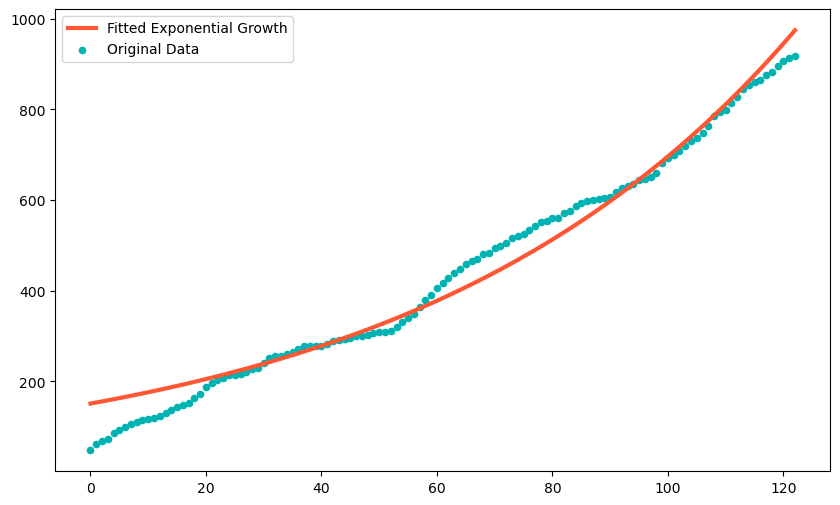

Estimated Parameters (a, b): [1.51120216e+02 1.52793638e-02]


In [240]:
from scipy.optimize import curve_fit

# function to define the form of the exponential model
def exponential_model(x, a, b):
    return a * np.exp(b * x)

# we need x to be the number of days since the start of the data
x = np.array(range(len(df['emails'])))

# we're predicting the number of subscribers, so y is just the 'emails' column
y = df['emails'].values

# fit the curve
popt, pcov = curve_fit(exponential_model, x, y, p0=(1, 0.01))

# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df.index, y, s=20, color='#00b3b3', label='Original Data')
plt.plot(df.index, exponential_model(x, *popt), color='#ff5733', linewidth=3, label='Fitted Exponential Growth')
plt.legend()
plt.show()

# print the parameters
print('Estimated Parameters (a, b):', popt)

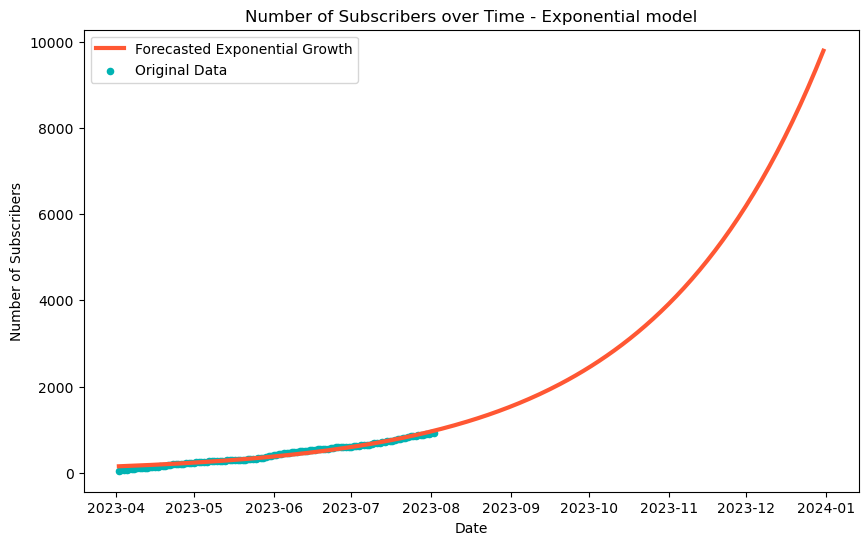

In [254]:
# number of days from the beginning of your data until three years from now
days_to_forecast = (pd.to_datetime('2024-1-1') - df.index[0]).days  # replace '2026-07-11' with the date three years from your last record

# create an array of x values representing the original timeframe plus the forecast period
x_forecast = np.array(range(days_to_forecast))

# use the exponential_model function and the estimated parameters to generate the y values
y_forecast = exponential_model(x_forecast, *popt)

# create a date range that includes the original dates and the forecast period
dates_forecast = pd.date_range(df.index[0], periods=days_to_forecast)

# plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.scatter(df.index, y, s=20, color='#00b3b3', label='Original Data')
plt.plot(dates_forecast, y_forecast, color='#ff5733', linewidth=3, label='Forecasted Exponential Growth')
plt.title('Number of Subscribers over Time - Exponential model')  
plt.xlabel('Date')  
plt.ylabel('Number of Subscribers')  
plt.legend()
plt.show()